## Project Information


**Author/Developer:**
- Alexandra Fischbach
- Contact: fischbach.a@northeastern.edu
- Affiliation: Northeastern University 

**Example Data Source for this Notebook:**
- Data is available on the OpenNeuro database (OpenNeuro Dataset, ds005747, version 1.2.1) - subject_id: 011
- Dataset Title: 7T fMRI Resting-state Dataset
- URL:  https://openneuro.org/datasets/ds005747/versions/1.2.1
- Version: 1.2.1
- DOI: doi:10.18112/openneuro.ds005747.v1.2.1


### Import required libraries

Import libraries and extend the Python path to allow access to project-level utility modules (e.g., from the `utils/` folder).


In [ ]:
# ------------------- IMPORT LIBRARIES  --------------------
import os 
import sys
import pandas as pd

# This allows imports from top-level folders like `utils/` when running notebooks from subdirectories.
sys.path.append(os.path.abspath('..'))  

### Define input paths and key parameters


In [ ]:
# ------------------- SET PATHS + PARAMS --------------------
out_dir = 'output/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

template_path = 'data/anat/MNI_template/mni_icbm152_t1_tal_nlin_asym_09c.nii.gz'

roi = 'PAG'
roi_path = f'data/anat/roi_mask/probabilistic/{roi}.nii.gz' 
# ------------------- SUBJECT SPECIFIC PATHS & PARAMS ----------------------
subj_id = 'sub-011'
csf_mask_path = f'data/anat/csf_prob_tissue/{subj_id}_T1w_space-MNI152NLin2009cAsym_class-CSF_probtissue.nii.gz'
func_mask_path= f'data/func/{subj_id}_task-rest_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
confound_file_path =  f'data/func/{subj_id}_task-rest_run-01_bold_confounds.tsv'


### Import local utility functions

Functions are imported from the `utils/` folder.

In [16]:
# ------------------- IMPORTS --------------------------------
from utils.process_roi import process_roi_mask, threshold_roi_mask, dilate_binary_roi_mask
from utils.extract_csf import extract_local_csf_mask, extract_local_csf_time_series, add_local_csf_time_series_to_confound_file
from utils.compute_timeseries import compute_timeseries
from utils.plot_roi import plot_roi_step


### Standardize ROI to deference space

>**Function type:** Optional preprocessing step.

**Purpose:**  Ensures all ROI masks are in the same anatomical space as the functional and CSF images, which is necessary for accurate alignment.

**Notes:**  
- Spatial mismatches between ROI and functional images will cause alignment errors downstream.
- If resampling is required, the interpolation method is selected automatically based on the mask type:
  - **`nearest`** — used for binary masks  
  - **`linear`** — used for probabilistic masks


Saving to basename: output/PAG
Loading ROI image from: data/anat/roi_mask/probabilistic/PAG.nii.gz

Loading template image from: data/anat/MNI_template/mni_icbm152_t1_tal_nlin_asym_09c.nii.gz

Resampling ROI to match template shape: (193, 229, 193).
Processed ROI mask saved to: output/PAG_proc.nii.gz



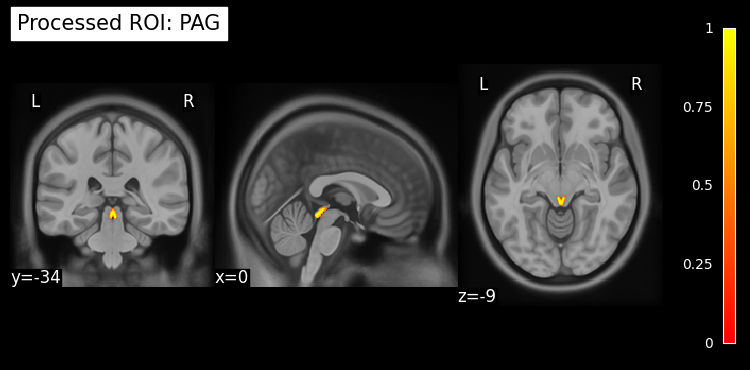

In [22]:
# -------------------- STEP 1 ------------------------------
file_basename = os.path.join(out_dir, roi)
print(f'Saving to basename: {file_basename}')

# Define output file path
proc_roi_path = file_basename + "_proc.nii.gz"

process_roi_mask(
    roi_path,
    template_path=template_path,
    save_path = proc_roi_path
)

plot_roi_step(proc_roi_path, template_path, title=f'Processed ROI: {roi}')

### Threshold ROI 

>**Function type:** Optional preprocessing step. 

**Purpose:** Thresholds the gray matter ROI mask (default = 0.2), if it is not already binary.

ROI mask is probabilistic. Thresholding to binary mask...
Values are within the expected [0, 1] range. Using threshold: 0.6.
Saved thresholded mask to /Users/alex/Library/CloudStorage/GoogleDrive-alexkfischbach@gmail.com/My Drive/scripts/local_csf_pipeline/test/output/PAG_binary.nii.gz


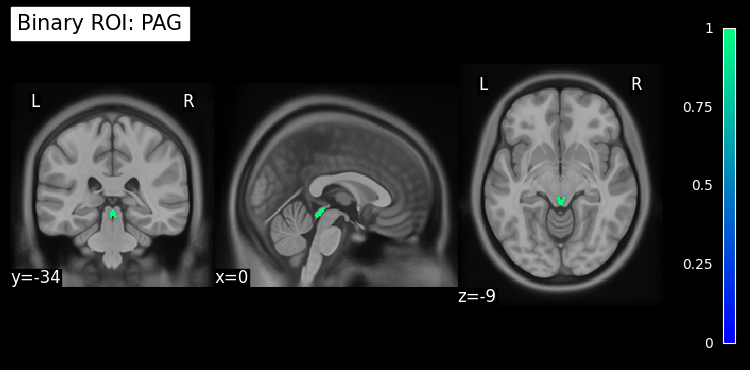

In [50]:
# -------------------- STEP 2 ------------------------------
# Define output file path
threshold_roi_path = file_basename + "_binary.nii.gz"

threshold_roi_mask(
    proc_roi_path,
    save_path = threshold_roi_path
)

plot_roi_step(threshold_roi_path, template_path, title=f'Binary ROI: {roi}', cmap='winter')

### Dilate binary ROI 

>**Function type:** Mandatory preprocessing. 

**Purpose:** Expands the binary ROI mask by a specified number of iterations (default = 4).

**Notes:**  
- Binary dilation is an operation that expands the ROI mask by adding neighboring voxels to the binary mask.
- The number of dilation iterations can be adjusted to control the extent of expansion. However, too many iterations may cause overlap with neighboring CSF regions not of interest.

Dilated mask saved to: /Users/alex/Library/CloudStorage/GoogleDrive-alexkfischbach@gmail.com/My Drive/scripts/local_csf_pipeline/test/output/PAG_dilated.nii.gz



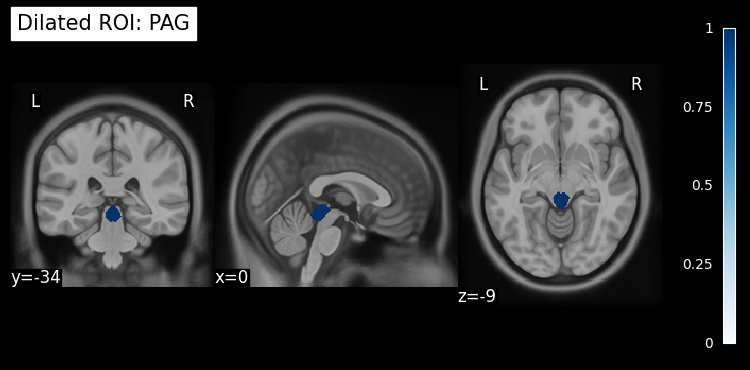

In [51]:
# -------------------- STEP 3 ------------------------------
# Define output file path
dilated_roi_path = file_basename + "_dilated.nii.gz"

dilate_binary_roi_mask(
    threshold_roi_path, 
    save_path = dilated_roi_path
)

plot_roi_step(dilated_roi_path, template_path, title=f'Dilated ROI: {roi}', cmap='Blues')

### Extract local CSF mask

>**Function type:** Mandatory preprocessing.

**Purpose:**  Creates a localized CSF mask by intersecting a CSF tissue probability map with a dilated ROI. This enables extraction of CSF signals from anatomically relevant regions adjacent to the ROI.

**Notes:**  
- CSF probability maps should be aligned with the functional and ROI space.
- The CSF tissue probability map is thresholded at **0.6** by default to identify high-confidence CSF voxels.

Thresholded CSF mask at 0.6.
Local CSF mask saved to: /Users/alex/Library/CloudStorage/GoogleDrive-alexkfischbach@gmail.com/My Drive/scripts/local_csf_pipeline/test/output/PAG_local_csf_mask.nii.gz



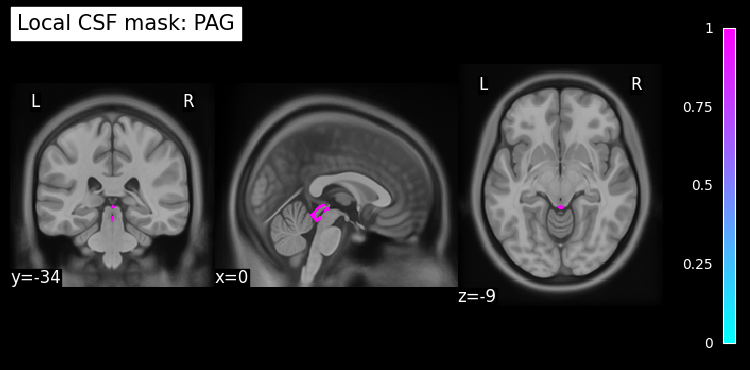

In [52]:
# -------------------- STEP 4 ------------------------------
# Define output file path
local_csf_mask_path = file_basename + "_local_csf_mask.nii.gz"

extract_local_csf_mask(
    csf_mask_path, 
    threshold_roi_path,
    dilated_roi_path, 
    save_path = local_csf_mask_path
)

plot_roi_step(local_csf_mask_path, template_path, title=f'Local CSF mask: {roi}', cmap='cool')

### Extract local CSF time series

>**Function type:** Mandatory preprocessing.

**Purpose:**  Extracts the average CSF time series from the local CSF mask and prepares it for use as a physiological nuisance regressor.

**Notes:**
- The output time series should be of length `n_TRs`, matching the BOLD image and confound regressors.

In [ ]:
# -------------------- STEP 5 ------------------------------
# Define output file path
local_csf_ts_path = file_basename + "_local_csf_ts.csv"

extract_local_csf_time_series(
    func_mask_path, 
    local_csf_mask_path, 
    roi,
    save_path = local_csf_ts_path
)

/Users/alex/PRISM_LAB/env_setup/my_virtual_env/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


### Add local CSF time series to confound file 

>**Function type:** Mandatory preprocessing.

**Purpose:**  Appends the average local CSF time series to the subject’s confound file  to enable region-specific nuisance regression.

**Notes:**  
- Original confounds are preserved.
- If processing multiple ROIs, the function automatically uses a standardized naming convention (e.g., `local_csf_PAG`, `local_csf_amygdala`) to avoid column name conflicts.

In [ ]:
# -------------------- STEP 6 ------------------------------
# Define output file path
mod_conf_path = os.path.join(out_dir, f"{subj_id}_confounds_mod.tsv")

add_local_csf_time_series_to_confound_file(
    confound_file_path, 
    local_csf_ts_path, 
    roi,
    save_path = mod_conf_path
)

Modified confound file saved to: /Users/alex/Library/CloudStorage/GoogleDrive-alexkfischbach@gmail.com/My Drive/scripts/local_csf_pipeline/test/output/sub-011_confounds_mod.tsv


,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,retroicor_coscos_cr1,retroicor_sincos_cr1,retroicor_cossin_cr1,retroicor_sinsin_cr1,hrv_x_crf,rvt_x_rrf,h_rate,rvt_1,ibi,PAG_local_csf
0,1668.903917,1086.265558,1342.221187,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.026272,-0.112569,67.039106,0.179044,895.000000,1693.163118
1,1587.657645,1079.587411,1310.089150,1.461214,102.023239,1.251889,0.075817,-0.018917,0.004582,-0.024739,...,-0.300450,0.953798,-0.363884,0.931444,0.023223,-0.141316,66.183423,0.555470,906.571429,1619.522290
2,1565.413114,1074.767300,1304.236017,1.363036,95.168365,1.189677,0.046858,-0.109302,-0.022800,0.060489,...,-0.510872,0.859657,-0.500943,0.865480,0.081704,-0.076634,65.563534,0.537958,915.142857,1595.223097
3,1559.985909,1076.680962,1302.303951,1.314647,91.789810,1.118734,0.062459,0.066566,-0.056455,0.072917,...,-0.696381,-0.717672,0.640778,0.767726,0.094708,-0.006780,66.133921,0.386146,907.250000,1617.329774
4,1554.592826,1075.898737,1301.208732,1.289611,90.041779,1.096179,0.045929,0.038673,0.011621,-0.101952,...,0.000000,0.000000,0.000000,0.000000,0.065285,-0.018575,67.286126,0.400727,891.714286,1591.933555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,1574.474184,1073.114864,1294.572325,0.929244,64.880630,0.876548,0.088870,-0.043562,0.107457,0.049624,...,-0.760096,-0.649811,-0.311284,0.950317,0.116265,-0.119045,63.349611,0.362716,947.125000,1596.541453
252,1565.465957,1071.653758,1291.990002,0.935160,65.293671,0.883930,0.090879,0.017179,0.008294,0.045648,...,0.000000,0.000000,0.000000,0.000000,0.033959,-0.104649,61.737469,0.328789,971.857143,1604.123189
253,1563.480948,1068.302347,1292.834059,0.927257,64.741898,0.873064,0.050725,0.023625,0.019845,0.024186,...,0.531092,0.847314,-0.809522,0.587089,-0.107253,-0.096130,62.808434,0.272152,955.285714,1590.626962
254,1556.202099,1064.036992,1291.621897,0.926723,64.704643,0.877851,0.047310,0.056927,0.035739,-0.023146,...,0.000000,0.000000,0.000000,0.000000,-0.162737,-0.094292,70.683272,0.312861,848.857143,1588.019299


### Compute corrected ROI time series

> **Function type:** Mandatory preprocessing.

**Purpose:**  Computes the functional time series for each ROI after regressing out the average local CSF time series and motion regressors 
(default = `['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']`) as nuisance variables.  
The resulting cleaned time series is saved as a `.csv` file.




In [ ]:
#-------------------- STEP 7: Compute Denoised ROI Time Series --
corrected_ts_path = os.path.join(out_dir, f"{subj_id}_{roi}_corrected_ts.csv")

compute_timeseries(
    func_mask_path, 
    threshold_roi_path, 
    mod_conf_path, 
    roi, 
    confound_vars = "Default", 
    save_path = corrected_ts_path
)

print(f"Pipeline completed. Outputs saved to {out_dir}")